**Portfolio Diversification Check** </br>
re-creation of python notebook from
https://www.youtube.com/watch?v=9mpN7n2wJkM

In [12]:
# !pip install yfinance --upgrade --quiet

In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import yfinance as yf
from scipy.optimize import minimize
from dateutil.relativedelta import relativedelta
from datetime import date

In [14]:
training_period = 0.7
lookback_period_years = 5

end_date = date.today().strftime('%Y-%m-%d')
start_date = (date.today() - relativedelta(years=lookback_period_years)).replace(month=1, day=1).strftime('%Y-%m-%d')

In [15]:
port1_list = ['ARCC', 'CLF', 'DLY', 'HUN', 'MAIN', 'MOS', 'MP', 'O', 'PHYS', 'RYLD', 'SLVO', 'STAG', 'USOI', 'XRMI']
port2_list = ['ARCC', 'QYLD', 'XRMI', 'PFLT', 'SCHD', '6823.HK', '2638.HK', '0939.HK', '3988.HK']
spy10_list = ['NVDA', 'MSFT', 'AAPL', 'AMZN', 'META', 'AVGO', 'GOOGL', 'BRK-B', 'TSLA', 'GOOG']

In [16]:
port1_org = yf.download(port1_list, start=start_date, end=end_date, auto_adjust=True, progress=False)
port2_org = yf.download(port2_list, start=start_date, end=end_date, auto_adjust=True, progress=False)
spy10_org = yf.download(spy10_list, start=start_date, end=end_date, auto_adjust=True, progress=False)

In [17]:
port1 = port1_org.Close[['ARCC', 'CLF', 'DLY', 'HUN', 'MAIN', 'MOS', 'MP', 'O', 'PHYS', 'RYLD', 'SLVO', 'STAG', 'USOI', 'XRMI']].pct_change(fill_method=None).fillna(0)
port2 = port2_org.Close[['ARCC', 'QYLD', 'XRMI', 'PFLT', 'SCHD', '6823.HK', '2638.HK', '0939.HK', '3988.HK']].pct_change(fill_method=None).fillna(0)
spy10 = spy10_org.Close[['NVDA', 'MSFT', 'AAPL', 'AMZN', 'META', 'AVGO', 'GOOGL', 'BRK-B', 'TSLA', 'GOOG']].pct_change(fill_method=None).fillna(0)

In [19]:
# generate heatmap
port1_close = port1_org['Close']
port2_close = port2_org['Close']
spy10_close = spy10_org['Close']

port1_corr = port1_close.corr()
port2_corr = port2_close.corr()
spy10_corr = spy10_close.corr()

Text(0.5, 1.0, 'Correlation Heatmap for Portfolio 2')

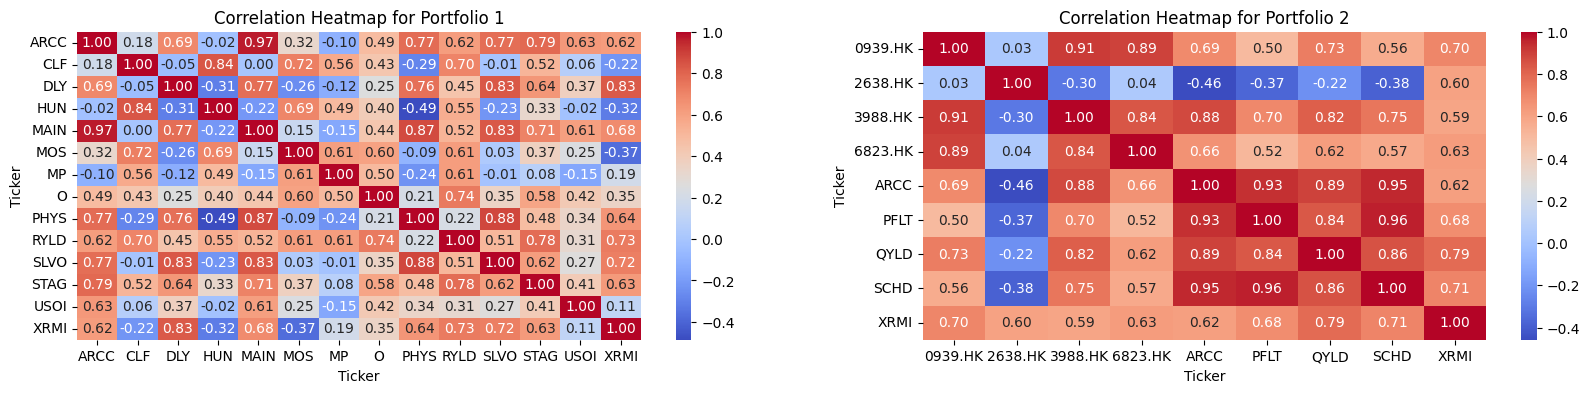

In [20]:
# setup portfolio 1 & 2 heatmap side by side
fig, axes = plt.subplots(1, 2, figsize=(20, 4))  # adjust figsize as needed

# Heatmap for Portfolio 1
sns.heatmap(port1_corr, annot=True, cmap='coolwarm', fmt=".2f", ax=axes[0])
axes[0].set_title('Correlation Heatmap for Portfolio 1')

# Heatmap for Portfolio 2
sns.heatmap(port2_corr, annot=True, cmap='coolwarm', fmt=".2f", ax=axes[1])
axes[1].set_title('Correlation Heatmap for Portfolio 2')

# heatmap - portfolio 3
# plt.figure(figsize=(9, 3))
# sns.heatmap(spy10_corr, annot=True, cmap='coolwarm', fmt=".2f")
# plt.title('Correlation Heatmap for SPY Top 10 Closing Prices')

array([0.27545146, 0.05269662])

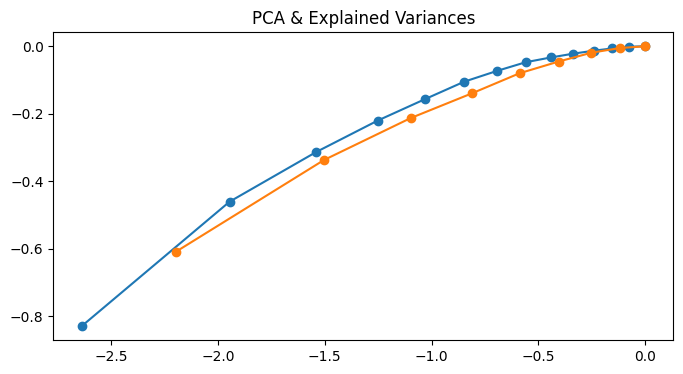

In [22]:
# PCA and Explained Variances
def ev(ret):
  eigvals,evecs = np.linalg.eig((ret-ret.mean()).cov())
  return np.cumsum(np.sort(eigvals)[::-1])/sum(eigvals)

plt.figure(figsize=(8, 4))
plt.title('PCA & Explained Variances')

plt.plot(np.log(np.arange(1,15)/14), np.log(ev(port1)), '-o')
plt.plot(np.log(np.arange(1,10)/9), np.log(ev(port2)), '-o')
# plt.plot(np.log(np.arange(1,11)/10), np.log(ev(spy10)), '-o')

np.polyfit(np.log(np.arange(1,15)/14), np.log(ev(port1)),1)
np.polyfit(np.log(np.arange(1,10)/9), np.log(ev(port2)),1)
# np.polyfit(np.log(np.arange(1,11)/10), np.log(ev(spy10)),1)

In [23]:
def sharpe(w, r):
  # sharpe ratio for each individual component
  # S = r.mul(w).mean()/r.mul(w).std()*16 # to roughly simulate 252 trading days in a year

  # sharpe ratio for entire portfolio
  S = r.mul(w).sum(axis=1).mean()/r.mul(w).sum(axis=1).std()*16

  return S

w1 = np.ones(14)/14
sr1 = sharpe(w1,port1)

w2 = np.ones(9)/9
sr2 = sharpe(w2,port2)

w_bench = np.ones(10)/10
sr_bench = sharpe(w_bench,spy10)
print(f"Sharpe Ratio of Portfolio 1: {sr1:.4f}")
print(f"Sharpe Ratio of Portfolio 2: {sr2:.4f}")
print(f"Sharpe Ratio of Benchmark SPY: {sr_bench:.4f}")

Sharpe Ratio of Portfolio 1: 0.6828
Sharpe Ratio of Portfolio 2: 0.8377
Sharpe Ratio of Benchmark SPY: 1.2037


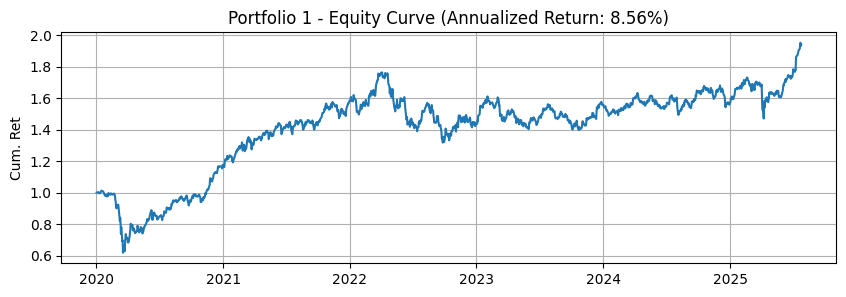

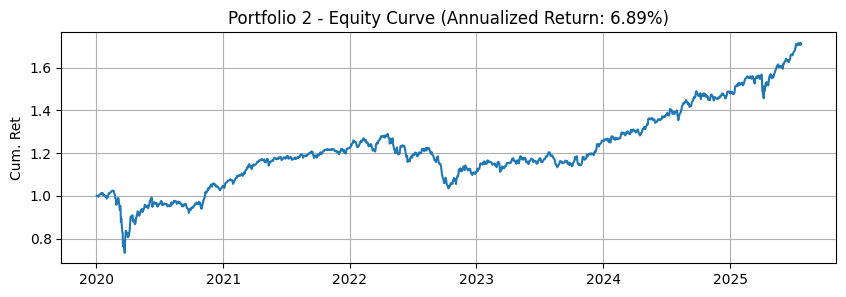

In [24]:
port1_ret = port1.dot(w1)
port2_ret = port2.dot(w2)
spy10_ret = spy10.dot(w_bench)


port1_ec = (1 + port1_ret).cumprod()
port2_ec = (1 + port2_ret).cumprod()
spy10_ec = (1 + spy10_ret).cumprod()

# Portfolio 1
port1_total_days = (port1_ec.index[-1] - port1_ec.index[0]).days
cagr = port1_ec.iloc[-1]**(252/port1_total_days) - 1

plt.figure(figsize=(10, 3))
plt.plot(port1_ec)
plt.title("Portfolio 1 - Equity Curve (Annualized Return: {:.2%})".format(cagr))
plt.ylabel("Cum. Ret")
plt.grid(True)

# Portfolio 2
port2_total_days = (port2_ec.index[-1] - port2_ec.index[0]).days
cagr = port2_ec.iloc[-1]**(252/port2_total_days) - 1

plt.figure(figsize=(10, 3))
plt.plot(port2_ec)
plt.title("Portfolio 2 - Equity Curve (Annualized Return: {:.2%})".format(cagr))
plt.ylabel("Cum. Ret")
plt.grid(True)

# SPY10 Benchmark
# spy10_total_days = (spy10_ec.index[-1] - spy10_ec.index[0]).days
# cagr = spy10_ec.iloc[-1]**(252/spy10_total_days) - 1

# plt.figure(figsize=(10, 3))
# plt.plot(spy10_ec)
# plt.title("SPY 10 Benchmark - Equity Curve (Annualized Return: {:.2%})".format(cagr))
# plt.ylabel("Cum. Ret")
# plt.grid(True)

**Diversification Co-efficient for Portfolio** <br>

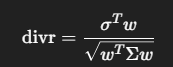
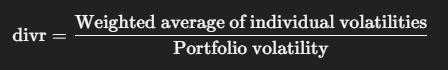
</br>

| **divr Score** | **Diversification Quality** | **Comment**                                                |
|----------------|-----------------------------|-------------------------------------------------------------|
| 1.0 – 1.2      | Poor                        | Minimal diversification — assets are highly correlated      |
| 1.2 – 1.5      | Fair                        | Some diversification but not great                          |
| 1.5 – 2.0      | Good                        | Strong diversification among assets                         |
| > 2.0          | Excellent                   | Very low correlation or sector/volatility-balanced portfolio |

In [25]:
#Diversification Co-efficient for Portfolio (volitility x strategy weight / correlation weight )
# more to compare like with like on portoflio sizes

port1_div_score = np.dot(w1.T, port1.std())/ np.sqrt(np.dot(np.dot(w1.T,port1.cov()),w1))
port2_div_score = np.dot(w2.T, port2.std())/ np.sqrt(np.dot(np.dot(w2.T,port2.cov()),w2))
spy10_div_score = np.dot(w_bench.T, spy10.std())/ np.sqrt(np.dot(np.dot(w_bench.T,spy10.cov()),w_bench))

print(f"Diversification Score of Portfolio 1: {port1_div_score:.4f}")
print(f"Diversification Score of Portfolio 2: {port2_div_score:.4f}")
print(f"Diversification Score of Benchmark SPY: {spy10_div_score:.4f}")

Diversification Score of Portfolio 1: 1.5899
Diversification Score of Portfolio 2: 1.6126
Diversification Score of Benchmark SPY: 1.3008


In [39]:
# determine if reinvestment of dividend is worth it
def calculate_portfolio_metrics(port1_list, port1, start_date, end_date, lookback_period_years, risk_free_rate=0.02):

    # Storage for all ratios
    sharpe_linear = {}
    sharpe_compound = {}
    calmar_ratios = {}
    avg_dividend_yields = {}  # Move this outside the loop
    cagr_values = {}

    for ticker in port1_list:
        try:
            # Get returns for this ticker
            returns = port1[ticker].dropna()  # Remove NaN values

            if len(returns) < 252:  # Need at least 1 year of data
                print(f"Warning: {ticker} has insufficient data ({len(returns)} days)")
                sharpe_linear[ticker] = np.nan
                sharpe_compound[ticker] = np.nan
                calmar_ratios[ticker] = np.nan
                avg_dividend_yields[ticker] = 0.0
                cagr_values[ticker] = np.nan
                continue

            # Basic statistics
            mu = returns.mean()
            sigma = returns.std()

            # CAGR calculation
            total_return = (1 + returns).prod() - 1
            years = len(returns) / 252
            cagr = (1 + total_return) ** (1/years) - 1
            cagr_values[ticker] = cagr

            # Linear Sharpe Ratio
            ann_return_linear = mu * 252
            ann_volatility = sigma * np.sqrt(252)
            sharpe_lin = (ann_return_linear - risk_free_rate) / ann_volatility if ann_volatility > 0 else np.nan

            # Compounded Sharpe Ratio
            ann_return_compound = (1 + mu) ** 252 - 1
            sharpe_comp = (ann_return_compound - risk_free_rate) / ann_volatility if ann_volatility > 0 else np.nan

            # Calmar Ratio - Calculate drawdowns properly
            cumulative = (1 + returns).cumprod()
            rolling_max = cumulative.expanding().max()
            drawdown = (cumulative - rolling_max) / rolling_max
            max_drawdown = drawdown.min()

            # Calmar ratio with better handling of edge cases
            if abs(max_drawdown) > 0.001:  # Only if max drawdown > 0.1%
                calmar = ann_return_compound / abs(max_drawdown)
            else:
                calmar = np.nan

            # Store results
            sharpe_linear[ticker] = sharpe_lin
            sharpe_compound[ticker] = sharpe_comp
            calmar_ratios[ticker] = calmar

            # Dividend yield calculation - FIXED: moved outside and properly structured
            try:
                tk = yf.Ticker(ticker)
                hist = tk.history(start=start_date, end=end_date, auto_adjust=True)

                if not hist.empty and 'Dividends' in hist.columns and hist['Dividends'].sum() > 0:
                    # Calculate annual dividends and average price
                    annual_divs = hist['Dividends'].resample('YE').sum()
                    annual_price = hist['Close'].resample('YE').mean()

                    # Calculate yield for each year where we have both dividends and prices
                    annual_yield = (annual_divs / annual_price).dropna()
                    avg_yield = annual_yield.mean() if not annual_yield.empty else 0.0

                    # Alternative method: total dividends / average price
                    if pd.isna(avg_yield) or avg_yield == 0:
                        total_dividends = hist['Dividends'].sum()
                        avg_price = hist['Close'].mean()
                        avg_yield = (total_dividends * 252 / len(hist)) / avg_price if avg_price > 0 else 0.0
                else:
                    avg_yield = 0.0

                avg_dividend_yields[ticker] = avg_yield

            except Exception as e:
                print(f"Error getting dividend data for {ticker}: {str(e)}")
                avg_dividend_yields[ticker] = 0.0

        except Exception as e:
            print(f"Error processing {ticker}: {str(e)}")
            sharpe_linear[ticker] = np.nan
            sharpe_compound[ticker] = np.nan
            calmar_ratios[ticker] = np.nan
            avg_dividend_yields[ticker] = 0.0
            cagr_values[ticker] = np.nan

    # Convert to pandas Series
    cagr_series = pd.Series(cagr_values)
    sharpe_linear_series = pd.Series(sharpe_linear)
    sharpe_compound_series = pd.Series(sharpe_compound)
    calmar_series = pd.Series(calmar_ratios)
    div_yield_series = pd.Series(avg_dividend_yields)

    # Estimate CAGR with dividends reinvested
    cagr_with_dividends = cagr_series + div_yield_series

    # Final value simulation
    initial_investment = 10000
    final_value_no_reinvest = initial_investment * (1 + cagr_series) ** lookback_period_years
    final_value_reinvest = initial_investment * (1 + cagr_with_dividends) ** lookback_period_years

    # Create summary DataFrame
    summary = pd.DataFrame({
        'Ticker': port1_list,
        'Price CAGR (%)': (cagr_series * 100).round(1),
        'Est. Avg Div Yield (%)': (div_yield_series * 100).round(1),
        'Est. CAGR w/ Dividends (%)': (cagr_with_dividends * 100).round(1),
        'Final Value (No Reinvest)': final_value_no_reinvest.round(-2).apply(lambda x: f"${int(x):,}" if pd.notna(x) else "N/A"),
        'Final Value (Reinvest)': final_value_reinvest.round(-2).apply(lambda x: f"${int(x):,}" if pd.notna(x) else "N/A"),
        'Sharpe (Linear)': sharpe_linear_series.round(2),
        'Sharpe (Compounded)': sharpe_compound_series.round(2),
        'Calmar Ratio': calmar_series.round(2),
    })

    # Sort by final value with reinvestment (handling NaN values)
    summary = summary.sort_values(by='Est. CAGR w/ Dividends (%)', ascending=False, na_position='last')

    return summary

In [42]:
print('Assume starting capital at 10k')
calculate_portfolio_metrics(port1_list, port1, start_date, end_date, lookback_period_years, risk_free_rate=0)

Assume starting capital at 10k


,Ticker,Price CAGR (%),Est. Avg Div Yield (%),Est. CAGR w/ Dividends (%),Final Value (No Reinvest),Final Value (Reinvest),Sharpe (Linear),Sharpe (Compounded),Calmar Ratio
USOI,USOI,-8.0,66.0,58.1,"$6,600","$98,600",-0.04,-0.04,-0.02
SLVO,SLVO,11.0,34.1,45.1,"$16,900","$64,400",0.57,0.61,0.37
MP,MP,39.0,0.0,39.0,"$51,800","$51,800",0.81,1.08,0.91
ARCC,ARCC,14.3,11.5,25.7,"$19,500","$31,400",0.58,0.64,0.36
MAIN,MAIN,16.5,8.8,25.3,"$21,400","$30,800",0.63,0.70,0.36
RYLD,RYLD,2.2,15.6,17.8,"$11,100","$22,600",0.21,0.21,0.10
PHYS,PHYS,14.2,0.0,14.2,"$19,400","$19,400",0.91,0.97,0.66
MOS,MOS,12.3,1.8,14.1,"$17,900","$19,300",0.49,0.55,0.40
DLY,DLY,3.3,9.8,13.1,"$11,800","$18,500",0.29,0.29,0.16
XRMI,XRMI,0.7,11.2,11.8,"$10,300","$17,500",0.14,0.14,0.05


In [43]:
print('Assume starting capital at 10k')
calculate_portfolio_metrics(port2_list, port2, start_date, end_date, lookback_period_years, risk_free_rate=0)

Assume starting capital at 10k


,Ticker,Price CAGR (%),Est. Avg Div Yield (%),Est. CAGR w/ Dividends (%),Final Value (No Reinvest),Final Value (Reinvest),Sharpe (Linear),Sharpe (Compounded),Calmar Ratio
ARCC,ARCC,13.7,11.5,25.2,"$19,000","$30,800",0.57,0.62,0.34
3988.HK,3988.HK,13.8,9.9,23.7,"$19,100","$28,900",0.81,0.87,0.70
QYLD,QYLD,6.9,16.3,23.1,"$13,900","$28,300",0.47,0.49,0.34
PFLT,PFLT,8.4,13.7,22.1,"$15,000","$27,200",0.41,0.44,0.23
0939.HK,0939.HK,10.9,9.2,20.1,"$16,800","$25,000",0.61,0.65,0.44
6823.HK,6823.HK,7.4,8.3,15.7,"$14,300","$20,800",0.52,0.54,0.37
SCHD,SCHD,11.9,3.6,15.5,"$17,600","$20,600",0.68,0.72,0.43
XRMI,XRMI,1.0,11.2,12.2,"$10,500","$17,800",0.21,0.21,0.08
2638.HK,2638.HK,0.2,5.6,5.7,"$10,100","$13,200",0.08,0.08,0.03
